In [6]:
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import grad
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ============== Parameters ==============
r = 0.05
sigma = 0.2
K = 40.0
T = 1.0
S_max = 160.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============== PINN Model ==============
class PINN(nn.Module):
    def __init__(self, layers, activation=nn.Tanh()):
        super(PINN, self).__init__()
        self.activation = activation
        self.linears = nn.ModuleList()
        for i in range(len(layers)-1):
            self.linears.append(nn.Linear(layers[i], layers[i+1]))
        # Xavier initialization
        for m in self.linears:
            nn.init.xavier_normal_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, x):
        for i in range(len(self.linears)-1):
            x = self.activation(self.linears[i](x))
        x = self.linears[-1](x)
        return x

def black_scholes_pde(V, S, t, r, sigma):
    V_t = grad(V, t, torch.ones_like(V), create_graph=True)[0]
    V_S = grad(V, S, torch.ones_like(V), create_graph=True)[0]
    V_SS = grad(V_S, S, torch.ones_like(V_S), create_graph=True, retain_graph=True)[0]
    pde = V_t + 0.5 * sigma**2 * S**2 * V_SS + r*S*V_S - r*V
    return pde

def terminal_condition(S, K):
    return torch.clamp(S - K, min=0.0)

def lower_boundary_condition(t):
    return torch.zeros_like(t)

def upper_boundary_condition(t, S_max, K, r, T):
    return S_max - K*torch.exp(-r*(T-t))

# ============== Training Data ==============
N_collocation = 20000
S_collocation_np = np.random.uniform(0, S_max, N_collocation)
t_collocation_np = np.random.uniform(0, T, N_collocation)

S_collocation = torch.tensor(S_collocation_np, dtype=torch.float32, device=device).unsqueeze(1)
t_collocation = torch.tensor(t_collocation_np, dtype=torch.float32, device=device).unsqueeze(1)
S_collocation.requires_grad = True
t_collocation.requires_grad = True

N_terminal = 200
S_terminal_np = np.linspace(0, S_max, N_terminal)
S_terminal = torch.tensor(S_terminal_np, dtype=torch.float32, device=device).unsqueeze(1)
t_terminal = torch.full_like(S_terminal, T)
V_terminal = terminal_condition(S_terminal, K)

N_boundary = 200
t_boundary_np = np.linspace(0, T, N_boundary)
t_boundary = torch.tensor(t_boundary_np, dtype=torch.float32, device=device).unsqueeze(1)

S_lower = torch.zeros_like(t_boundary)
V_lower = lower_boundary_condition(t_boundary)
S_upper = torch.full_like(t_boundary, S_max)
V_upper = upper_boundary_condition(t_boundary, S_max, K, r, T)

layers = [2, 64, 64, 64, 64, 1]
model = PINN(layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

lambda_pde = 1.0
lambda_term = 1.0
lambda_bvp = 1.0

epochs = 10000

#lose
loss_record_total = []
loss_record_pde = []
loss_record_term = []
loss_record_bvp = []

for epoch in range(epochs):
    optimizer.zero_grad()

    V_coll = model(torch.cat([S_collocation, t_collocation], dim=1))
    pde_residual = black_scholes_pde(V_coll, S_collocation, t_collocation, r, sigma)
    loss_pde = torch.mean(pde_residual**2)

    V_term_pred = model(torch.cat([S_terminal, t_terminal], dim=1))
    loss_term = torch.mean((V_term_pred - V_terminal)**2)

    V_lower_pred = model(torch.cat([S_lower, t_boundary], dim=1))
    V_upper_pred = model(torch.cat([S_upper, t_boundary], dim=1))
    loss_lower = torch.mean((V_lower_pred - V_lower)**2)
    loss_upper = torch.mean((V_upper_pred - V_upper)**2)
    loss_bvp = loss_lower + loss_upper

    loss = lambda_pde*loss_pde + lambda_term*loss_term + lambda_bvp*loss_bvp
    loss.backward()
    optimizer.step()

    # lose recording
    loss_record_total.append(loss.item())
    loss_record_pde.append(loss_pde.item())
    loss_record_term.append(loss_term.item())
    loss_record_bvp.append(loss_bvp.item())

    if epoch % 2000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, PDE: {loss_pde.item()}, Term: {loss_term.item()}, BVP: {loss_bvp.item()}")

print("Training completed.")



Epoch 0, Loss: 18409.67578125, PDE: 0.001610577804967761, Term: 3660.681640625, BVP: 14748.9921875
Epoch 2000, Loss: 504.1446838378906, PDE: 15.227134704589844, Term: 21.844972610473633, BVP: 467.07257080078125
Epoch 4000, Loss: 4.842830657958984, PDE: 0.9282025098800659, Term: 0.3344372510910034, BVP: 3.580191135406494
Epoch 6000, Loss: 0.13005313277244568, PDE: 0.02961520478129387, Term: 0.09640560299158096, BVP: 0.004032331518828869
Epoch 8000, Loss: 1.3745821714401245, PDE: 0.7586624026298523, Term: 0.15853862464427948, BVP: 0.45738112926483154
Training completed.


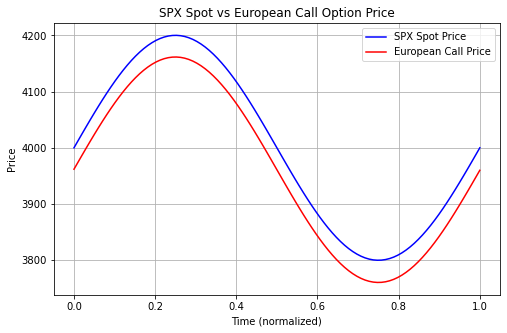

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def bs_call_price(S, t, K, r, sigma, T):
    # numpy to torch
    S_t = torch.tensor(S, dtype=torch.float32)
    t_t = torch.tensor(t, dtype=torch.float32)

    # tau = T-t
    tau_t = T - t_t

    # Torch
    d1_t = (torch.log(S_t/K) + (r + 0.5*sigma**2)*tau_t) / (sigma*torch.sqrt(tau_t))
    d2_t = d1_t - sigma*torch.sqrt(tau_t)

    # erf normal distribution
    # N(x) = 0.5*(1 + erf(x/sqrt(2)))
    sqrt2_t = torch.sqrt(torch.tensor(2.0))
    N = lambda x: 0.5*(1.0 + torch.erf(x/sqrt2_t))

    # exp function
    price_t = S_t*N(d1_t) - K*torch.exp(-r*tau_t)*N(d2_t)

    # reverse numpy
    return price_t.cpu().numpy()


time_series = np.linspace(0,1,100)
spx_prices = 4000 + 200*np.sin(2*np.pi*time_series) # SPX spot price

K = 40.0
r = 0.05
sigma = 0.2
T = 1.0

call_prices = bs_call_price(spx_prices, time_series, K, r, sigma, T)

plt.figure(figsize=(8,5))
plt.plot(time_series, spx_prices, label='SPX Spot Price', color='blue')
plt.plot(time_series, call_prices, label='European Call Price', color='red')
plt.xlabel('Time (normalized)')
plt.ylabel('Price')
plt.title('SPX Spot vs European Call Option Price')
plt.legend()
plt.grid(True)
plt.show()

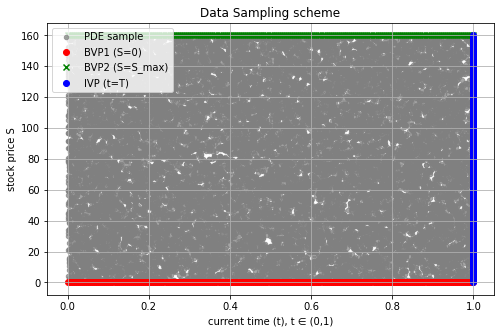

In [12]:
# 2. Map of data sampling scheme (BVP1, BVP2, IVP & PDE sampling)
# S_collocation,t_collocation, S_lower,t_boundary, S_upper,t_boundary, S_terminal,t_terminal in the training data
# Corresponds to BVP1: S=0 line, BVP2: S=S_max line, IVP: t=T line

plt.figure(figsize=(8,5))
plt.scatter(t_collocation_np, S_collocation_np, c='gray', s=20, alpha=0.7, label='PDE sample')
plt.scatter(t_boundary_np, np.zeros_like(t_boundary_np), c='red', label='BVP1 (S=0)')
plt.scatter(t_boundary_np, np.full_like(t_boundary_np,S_max), c='green', marker='x', label='BVP2 (S=S_max)')
plt.scatter(np.full_like(S_terminal_np, T), S_terminal_np, c='blue', label='IVP (t=T)')
plt.xlabel('current time (t), t ∈ (0,1)')
plt.ylabel('stock price S')
plt.title('Data Sampling scheme')
plt.legend()
plt.grid(True)
plt.show()

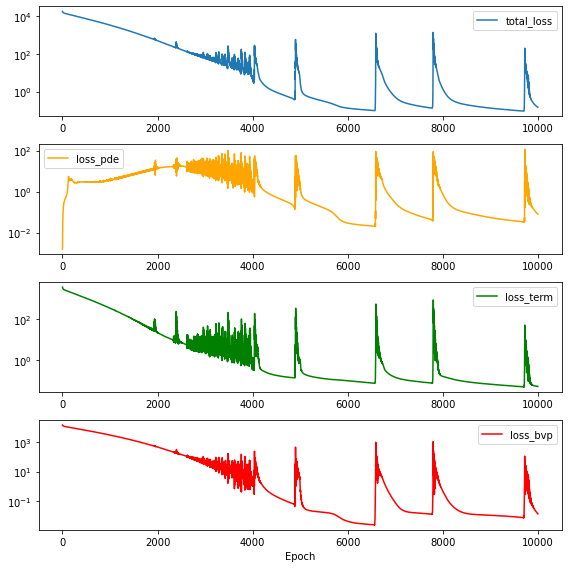

In [14]:
# 3. Training process loss graph (log scale)
epochs_array = np.arange(epochs)

# Assume that loss_record_bvp represents the total BVP loss, loss_record_term represents the term loss, and loss_record_pde represents the PDE residual loss
# This can be appropriately adjusted to the subgraph level of image 2

plt.figure(figsize=(8,8))
plt.subplot(4,1,1)
plt.plot(epochs_array, loss_record_total, label='total_loss')
plt.yscale('log')
plt.legend()

plt.subplot(4,1,2)
plt.plot(epochs_array, loss_record_pde, label='loss_pde', color='orange')
plt.yscale('log')
plt.legend()

plt.subplot(4,1,3)
plt.plot(epochs_array, loss_record_term, label='loss_term', color='green')
plt.yscale('log')
plt.legend()

plt.subplot(4,1,4)
plt.plot(epochs_array, loss_record_bvp, label='loss_bvp', color='red')
plt.yscale('log')
plt.legend()

plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

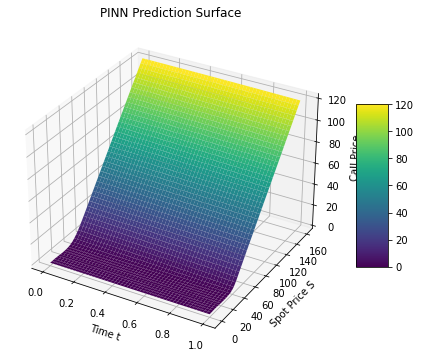

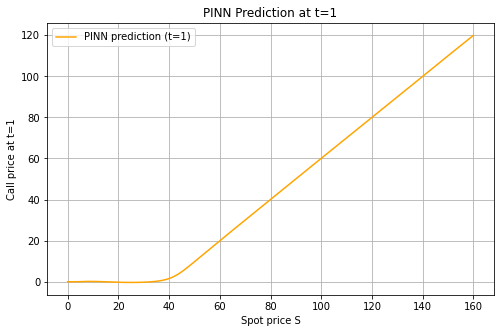

In [15]:
# 4. Plot of PINN prediction results
# Generate 3D surface (S,t) -> V_pinn
S_vals = np.linspace(0,160,50)
t_vals = np.linspace(0,1,50)
S_grid, t_grid = np.meshgrid(S_vals, t_vals)

# tensor
S_in = torch.tensor(S_grid.flatten(), dtype=torch.float32, device=device).unsqueeze(1)
t_in = torch.tensor(t_grid.flatten(), dtype=torch.float32, device=device).unsqueeze(1)
with torch.no_grad():
    V_pred_flat = model(torch.cat([S_in, t_in],dim=1)).cpu().numpy()
V_pinn_surf = V_pred_flat.reshape(S_grid.shape)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(t_grid, S_grid, V_pinn_surf, cmap='viridis')
ax.set_xlabel('Time t')
ax.set_ylabel('Spot Price S')
ax.set_zlabel('Call Price')
ax.set_title('PINN Prediction Surface')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# t=1 cross section, PINN prediction comparison
S_line = np.linspace(0,160,200)
t_line = np.ones_like(S_line)*T
S_line_t = torch.tensor(S_line, dtype=torch.float32, device=device).unsqueeze(1)
t_line_t = torch.tensor(t_line, dtype=torch.float32, device=device).unsqueeze(1)
with torch.no_grad():
    V_line_pred = model(torch.cat([S_line_t, t_line_t], dim=1)).cpu().numpy()

plt.figure(figsize=(8,5))
plt.plot(S_line, V_line_pred, label='PINN prediction (t=1)', color='orange')
plt.xlabel('Spot price S')
plt.ylabel('Call price at t=1')
plt.title('PINN Prediction at t=1')
plt.legend()
plt.grid(True)
plt.show()